### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

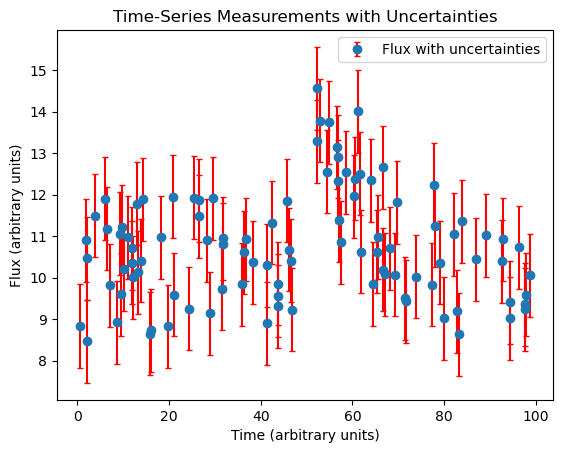

In [22]:
#part 1
import numpy as np
import matplotlib.pyplot as plt

data = np.load('hw5_data_1.npy')
time = data[:, 0]
flux = data[:, 1]
uncertainties = data[:, 2]

plt.errorbar(time, flux, yerr=uncertainties, fmt='o', ecolor='red', capsize=2, label='Flux with uncertainties')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Time-Series Measurements with Uncertainties')
plt.legend()
plt.show()

In [30]:
#part 2
def burst_model(t, b, A, t0, alpha):
    y = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
    return y

def log_likelihood(params, t, y, yerr):
    b, A, t0, alpha = params
    model = burst_model(t, b, A, t0, alpha)
    chi2 = np.sum(((y - model) / yerr) ** 2)
    return -0.5 * chi2
    
test_params = [1.0, 2.0, 50.0, 0.1] 
test_model = burst_model(time, *test_params)
test_likelihood = log_likelihood(test_params, time, flux, uncertainties)

print(f"Test log-likelihood value: {test_likelihood}")

Test log-likelihood value: -4593.524760218172


In [31]:
#part 3
import corner
import emcee
def log_prior(params):
    b, A, t0, ln_alpha = params
    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < ln_alpha < 5:
        return 0.0
    return -np.inf

def log_posterior(params, t, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, y, yerr)

ndim = 4
nwalkers = 50
nsteps = 20000

initial_params = [1.0, 1.0, 50.0, 0.0]
pos = initial_params + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(time, flux, uncertainties))
sampler.run_mcmc(pos, nsteps)

samples = sampler.get_chain()

In [33]:
#part 4
nsteps = 100000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(time, flux, uncertainties))
sampler.run_mcmc(pos, nsteps)
tau = sampler.get_autocorr_time()
print(f"Auto-correlation time: {tau}")

burnin = int(2 * np.max(tau))
thin = int(np.max(tau) / 2)
samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(f"Number of samples after thinning: {len(samples)}")

Auto-correlation time: [ 62.96239486 162.2925206  338.1324358  469.04583368]
Number of samples after thinning: 21150


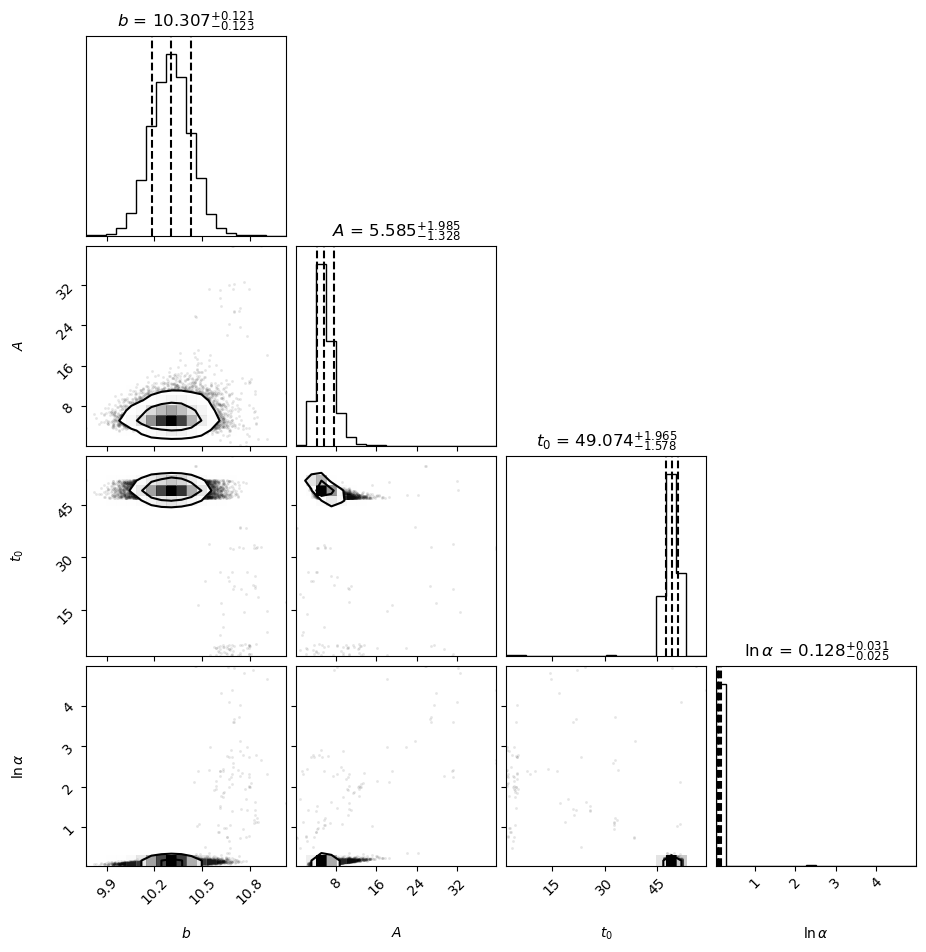

In [34]:
#part 5
fig = corner.corner(
    samples,
    labels=[r"$b$", r"$A$", r"$t_0$", r"$\ln \alpha$"],
    levels=(0.68, 0.95),
    show_titles=True,
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.50, 0.84],
    title_fmt='.3f'
)

plt.show()

<span style="color:red"> NP: are you modeling `ln(alpha)` or just `alpha`? -1 pt </span>

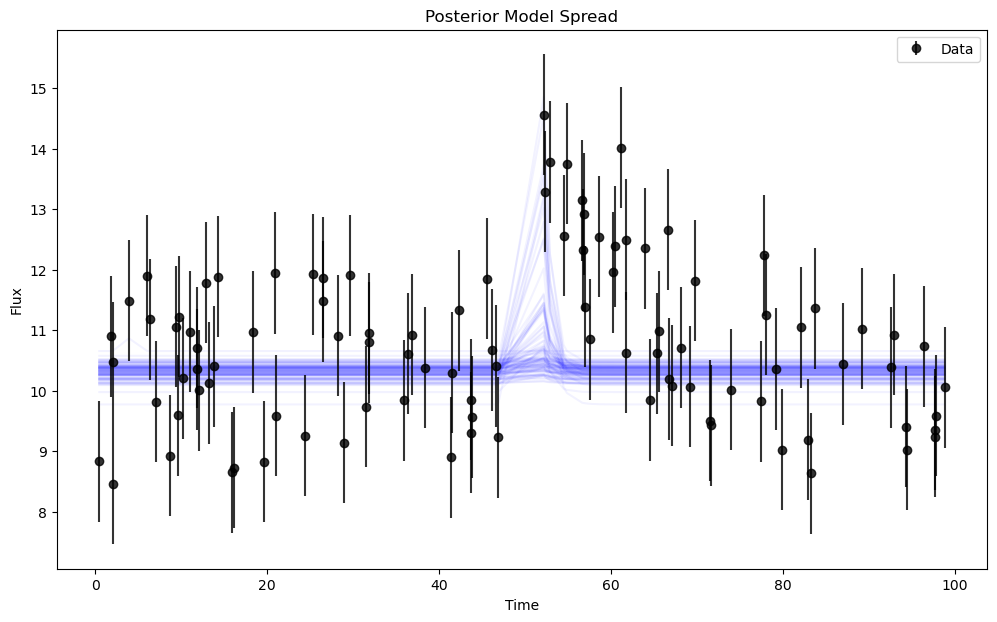

In [36]:
#part 6
random_idx = np.random.randint(0, len(samples), 100)
random_samples = samples[random_idx]

plt.figure(figsize=(12, 7))

plt.errorbar(time, flux, yerr=uncertainties, fmt='o', color='black', 
             label='Data', zorder=1000, alpha=0.8)

for params in random_samples:
    b, A, t0, ln_alpha = params
    alpha = np.exp(ln_alpha)
    model = burst_model(time, b, A, t0, alpha)
    plt.plot(time, model, color='blue', alpha=0.05)

plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Posterior Model Spread')
plt.legend()
plt.show()

<span style="color:red"> NP: this plot should also have clued you into whether you are setting up your model correctly. -1 pt </span>

In [ ]:
#part 7
import dynesty

def gaussian_model(t, b, A, t0, sigma_W):
    return b + A * np.exp(-0.5 * ((t - t0) / sigma_W) ** 2)

def log_likelihood_burst(params):
    b, A, t0, ln_alpha = params
    alpha = np.exp(ln_alpha)
    model = burst_model(time, b, A, t0, alpha)
    chi2 = np.sum(((flux - model) / uncertainties) ** 2)
    return -0.5 * chi2

def log_likelihood_gaussian(params):
    b, A, t0, ln_sigma_W = params
    sigma_W = np.exp(ln_sigma_W)
    model = gaussian_model(time, b, A, t0, sigma_W)
    chi2 = np.sum(((flux - model) / uncertainties) ** 2)
    return -0.5 * chi2

def prior_transform_burst(ucube):
    b = 50 * ucube[0]
    A = 50 * ucube[1]
    t0 = 100 * ucube[2]
    ln_alpha = -5 + 10 * ucube[3]
    return b, A, t0, ln_alpha

def prior_transform_gaussian(ucube):
    b = 50 * ucube[0]
    A = 50 * ucube[1]
    t0 = 100 * ucube[2]
    ln_sigma_W = -2 + 4 * ucube[3]
    return b, A, t0, ln_sigma_W

sampler_burst = dynesty.NestedSampler(
    log_likelihood_burst, 
    prior_transform_burst, 
    ndim=4, 
    nlive=1000,
    bound='multi'
)
sampler_burst.run_nested()
results_burst = sampler_burst.results

sampler_gaussian = dynesty.NestedSampler(
    log_likelihood_gaussian, 
    prior_transform_gaussian, 
    ndim=4, 
    nlive=1000,
    bound='multi'
)
sampler_gaussian.run_nested()
results_gaussian = sampler_gaussian.results

logZ_burst = results_burst.logz[-1]
logZ_gaussian = results_gaussian.logz[-1]
bayes_factor = np.exp(logZ_burst - logZ_gaussian)

fig_burst = corner.corner(
    results_burst.samples,
    labels=["b", "A", "t0", "ln_alpha"],
    show_titles=True
)
plt.show()

fig_gaussian = corner.corner(
    results_gaussian.samples,
    labels=["b", "A", "t0", "ln_sigma_W"],
    show_titles=True
)
plt.show()

print(f"Log evidence burst: {logZ_burst:.2f}")
print(f"Log evidence Gaussian: {logZ_gaussian:.2f}")
print(f"Bayes factor (burst/Gaussian): {bayes_factor:.2f}")

C:\Users\kdcow\AppData\Local\Temp\ipykernel_26020\97477311.py:3: RuntimeWarning: overflow encountered in exp
  y = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\kdcow\AppData\Local\Temp\ipykernel_26020\97477311.py:3: RuntimeWarning: overflow encountered in multiply
  y = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
iter: 3611 | bound: 0 | nc: 82 | ncall: 36140 | eff(%):  9.992 | loglstar:   -inf < -180.157 <    inf | logz: -188.753 +/-  0.088 | dlogz: 115.742 >  1.009                                           C:\Users\kdcow\AppData\Local\Temp\ipykernel_26020\97477311.py:3: RuntimeWarning: overflow encountered in exp
  y = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\kdcow\AppData\Local\Temp\ipykernel_26020\97477311.py:3: RuntimeWarning: overflow encountered in multiply
  y = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
iter: 3680 | bound: 1 | nc: 13 | ncall: 37588 | eff(%):  9.790 | loglstar:   -inf < -168.657 <    inf | logz: -1

<span style="color:red"> NP: I do not see the final numbers for the BF, or your conclusion. -1 pt </span>